<a href="https://colab.research.google.com/github/BTExpress1/ultimate-tech/blob/main/notebooks/ultimate_tech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import os
import io
import requests
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint
# from sklearn.impute import SimpleImputer # Not needed in this case. I used the mean to input the few missing data.



In [49]:
def load_and_group_dataframe(shareable_link):
    """
    Loads a JSON file from a Google Drive shareable link into a pandas DataFrame
    and displays the head of the DataFrame with columns grouped by numerical
    and then non-numerical data types.

    Args:
        shareable_link (str): The "Anyone with the link can view" link to the
                              JSON file on Google Drive.
    """
    file_id = None
    if "/d/" in shareable_link and "/view" in shareable_link:
        file_id = shareable_link.split("/d/")[1].split("/view")[0]
    elif "/file/d/" in shareable_link and "/edit" in shareable_link:
        file_id = shareable_link.split("/file/d/")[1].split("/edit")[0]

    if file_id:
        download_url = f"https://drive.google.com/uc?id={file_id}&export=download"

        try:
            response = requests.get(download_url)
            response.raise_for_status()  # Raise an exception for bad status codes

            # Read the JSON data directly from the response content
            ut_data = pd.read_json(io.StringIO(response.text))
            print("Data loaded successfully from Google Drive:")

            # Separate numerical and non-numerical columns
            numerical_cols = ut_data.select_dtypes(include=['number']).columns.tolist()
            non_numerical_cols = ut_data.select_dtypes(exclude=['number']).columns.tolist()

            # Create the desired column order
            ordered_cols = numerical_cols + non_numerical_cols

            # Display the DataFrame with the ordered columns (showing the head)
            #print(ut_data[ordered_cols].head())

            return ut_data  # Return the loaded DataFrame

        except requests.exceptions.RequestException as e:
            print(f"Error downloading file from Google Drive: {e}")
            return None
        except pd.errors.EmptyDataError:
            print("Error: The downloaded file appears to be empty.")
            return None
        except Exception as e:
            print(f"An error occurred while processing the downloaded data: {e}")
            return None

    else:
        print("Error: Could not extract file ID from the shareable link. Please ensure the link is correct.")
        return None

In [50]:
def find_n_plus_duplicate_timestamps(df, column_name='login_time', n=3):
    """
    Finds 'login timestamp' values that appear n or more times in the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to check.
        column_name (str): The name of the timestamp column. Defaults to 'login timestamp'.
        n (int): The minimum number of times a timestamp must be duplicated.
                 Defaults to 3.

    Returns:
        pd.DataFrame: A DataFrame containing all rows where the 'login timestamp'
                      appears n or more times.
    """
    if column_name not in df.columns:
        print(f"Error: Column '{column_name}' not found in the DataFrame.")
        return pd.DataFrame()

    timestamp_counts = df[column_name].value_counts()
    n_plus_duplicate_timestamps = timestamp_counts[timestamp_counts >= n].index.tolist()

    if n_plus_duplicate_timestamps:
        n_plus_duplicates_df = df[df[column_name].isin(n_plus_duplicate_timestamps)]
        return n_plus_duplicates_df.sort_values(by=column_name)
    else:
        print(f"No 'login timestamp' values appear {n} or more times.")
        return pd.DataFrame()

### Part 1

In [51]:
shareable_link = "https://drive.google.com/file/d/1ZA1-IVF15jD_IIIxCQ6a8dEG94Qf9raz/view?usp=drive_link"
ult_data = load_and_group_dataframe(shareable_link)

# Work with the DataFrame if it was loaded successfully
if ult_data is not None:
    # View the new DataFrame for further analysis or processing
    print("\nDataFrame shape:", ult_data.shape)

ult_data.head()

Data loaded successfully from Google Drive:

DataFrame shape: (93142, 1)


,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [52]:
ult_data.isnull().sum()

,0
login_time,0


In [53]:
# Group the login timestamps by 15 min increaments
ult_data['login_time'] = pd.to_datetime(ult_data['login_time'])
ult_data['login_time_15min'] = ult_data['login_time'].dt.floor('15min')
ult_grouped = ult_data.groupby('login_time_15min').size().reset_index(name='count')

In [54]:
ult_grouped.head()

,login_time_15min,count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


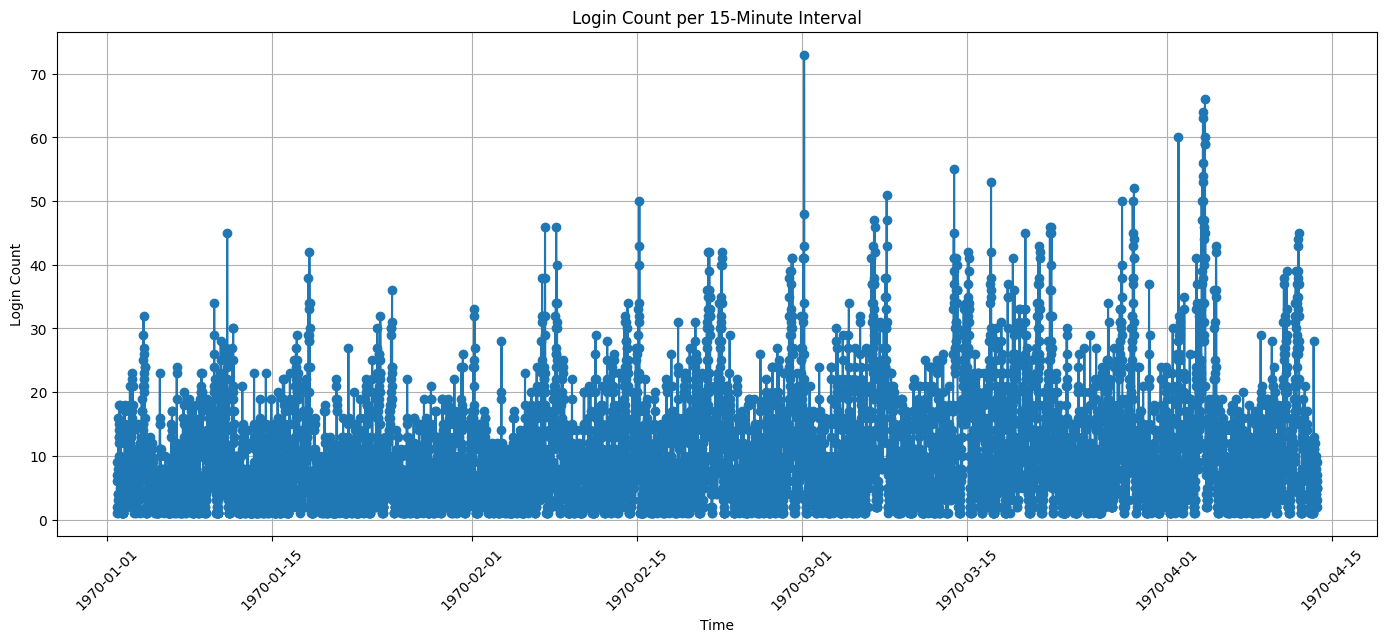

In [55]:
plt.figure(figsize=(14, 6))
plt.plot(ult_grouped['login_time_15min'], ult_grouped['count'], marker='o', linestyle='-')
plt.title('Login Count per 15-Minute Interval')
plt.xlabel('Time')
plt.ylabel('Login Count')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


<ipython-input-56-c41c7123e960>:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  time_of_day_summary['time_of_day_dt'] = pd.to_datetime(time_of_day_summary['time_of_day'].astype(str))


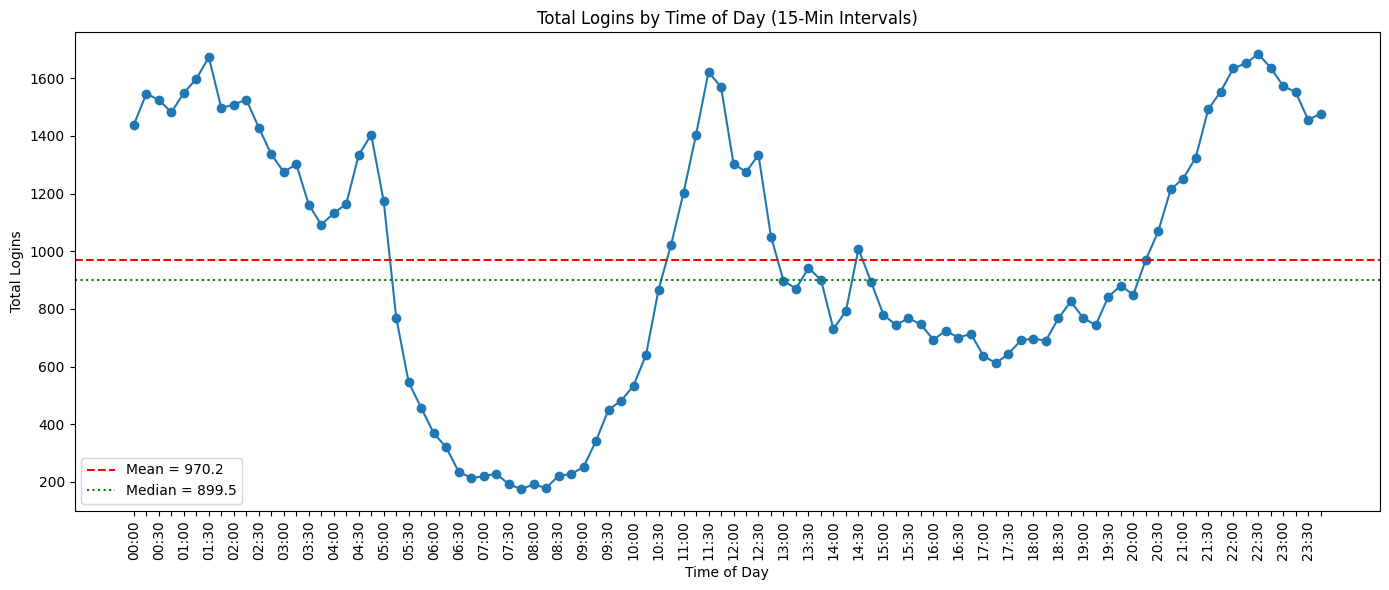

In [56]:
# Extract time of day from existing 15-min group
ult_grouped['time_of_day'] = ult_grouped['login_time_15min'].dt.time

# Aggregate across all days by time of day
time_of_day_summary = ult_grouped.groupby('time_of_day')['count'].sum().reset_index()

# Convert time to datetime for plotting
time_of_day_summary['time_of_day_dt'] = pd.to_datetime(time_of_day_summary['time_of_day'].astype(str))

mean_val = time_of_day_summary['count'].mean()
median_val = time_of_day_summary['count'].median()

x_labels = time_of_day_summary['time_of_day_dt'].dt.strftime('%H:%M')
x_ticks = range(len(x_labels))

# Plot
plt.figure(figsize=(14, 6))
plt.plot(time_of_day_summary['time_of_day_dt'].dt.strftime('%H:%M'), time_of_day_summary['count'], marker='o')
plt.axhline(mean_val, color='red', linestyle='--', label=f'Mean = {mean_val:.1f}')
plt.axhline(median_val, color='green', linestyle=':', label=f'Median = {median_val:.1f}')
plt.title('Total Logins by Time of Day (15-Min Intervals)')
plt.xlabel('Time of Day')
plt.ylabel('Total Logins')
plt.xticks(ticks=x_ticks, labels=[label if i % 2 == 0 else '' for i, label in enumerate(x_labels)], rotation=90)
plt.legend()
#plt.grid(True)
plt.tight_layout()
plt.show()


In [57]:
# How many data points do we have above and below the lines?
# Mean
above_mean = (time_of_day_summary['count'] > mean_val).sum()
below_mean = (time_of_day_summary['count'] <= mean_val).sum()

# Median
above_median = (time_of_day_summary['count'] > median_val).sum()
below_median = (time_of_day_summary['count'] <= median_val).sum()

print(f"Above Mean: {above_mean}, Below or Equal to Mean: {below_mean}")
print(f"Above Median: {above_median}, Below or Equal to Median: {below_median}")


Above Mean: 45, Below or Equal to Mean: 51
Above Median: 48, Below or Equal to Median: 48


In [58]:
# What is the total logins above and below the lines
# Mean
total_above_mean = time_of_day_summary.loc[time_of_day_summary['count'] > mean_val, 'count'].sum()
total_below_mean = time_of_day_summary.loc[time_of_day_summary['count'] <= mean_val, 'count'].sum()

# Median
total_above_median = time_of_day_summary.loc[time_of_day_summary['count'] > median_val, 'count'].sum()
total_below_median = time_of_day_summary.loc[time_of_day_summary['count'] <= median_val, 'count'].sum()

print(f"Logins Above Mean: {total_above_mean}, Below or Equal to Mean: {total_below_mean}")
print(f"Logins Above Median: {total_above_median}, Below or Equal to Median: {total_below_median}")


Logins Above Mean: 62513, Below or Equal to Mean: 30629
Logins Above Median: 65326, Below or Equal to Median: 27816


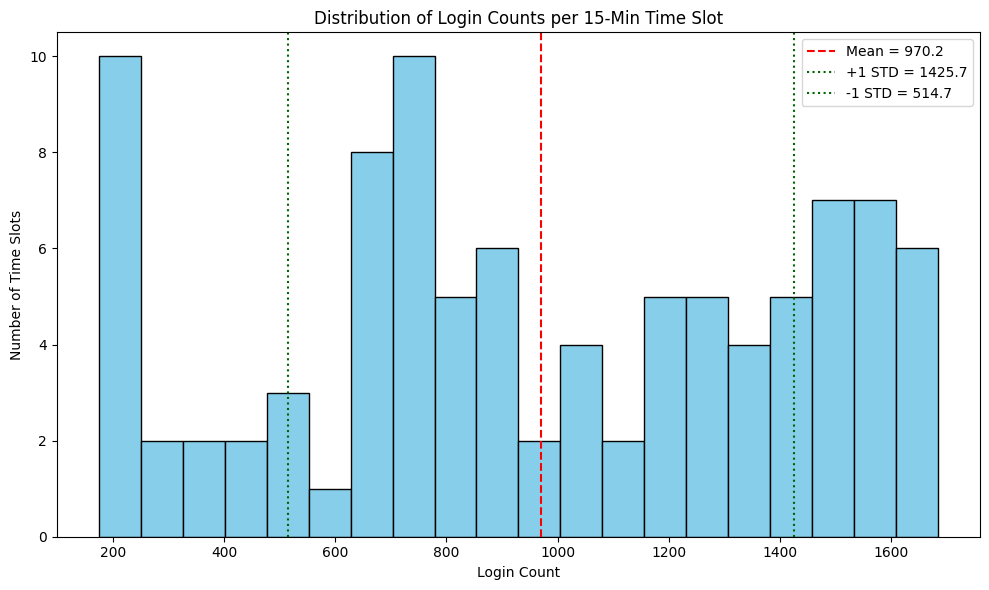

In [59]:
# Stats
mean_val = time_of_day_summary['count'].mean()
std_val = time_of_day_summary['count'].std()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(time_of_day_summary['count'], bins=20, color='skyblue', edgecolor='black')
plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean = {mean_val:.1f}')
plt.axvline(mean_val + std_val, color='darkgreen', linestyle=':', label=f'+1 STD = {mean_val + std_val:.1f}')
plt.axvline(mean_val - std_val, color='darkgreen', linestyle=':', label=f'-1 STD = {mean_val - std_val:.1f}')
plt.title('Distribution of Login Counts per 15-Min Time Slot')
plt.xlabel('Login Count')
plt.ylabel('Number of Time Slots')
plt.legend()
plt.tight_layout()
plt.show()


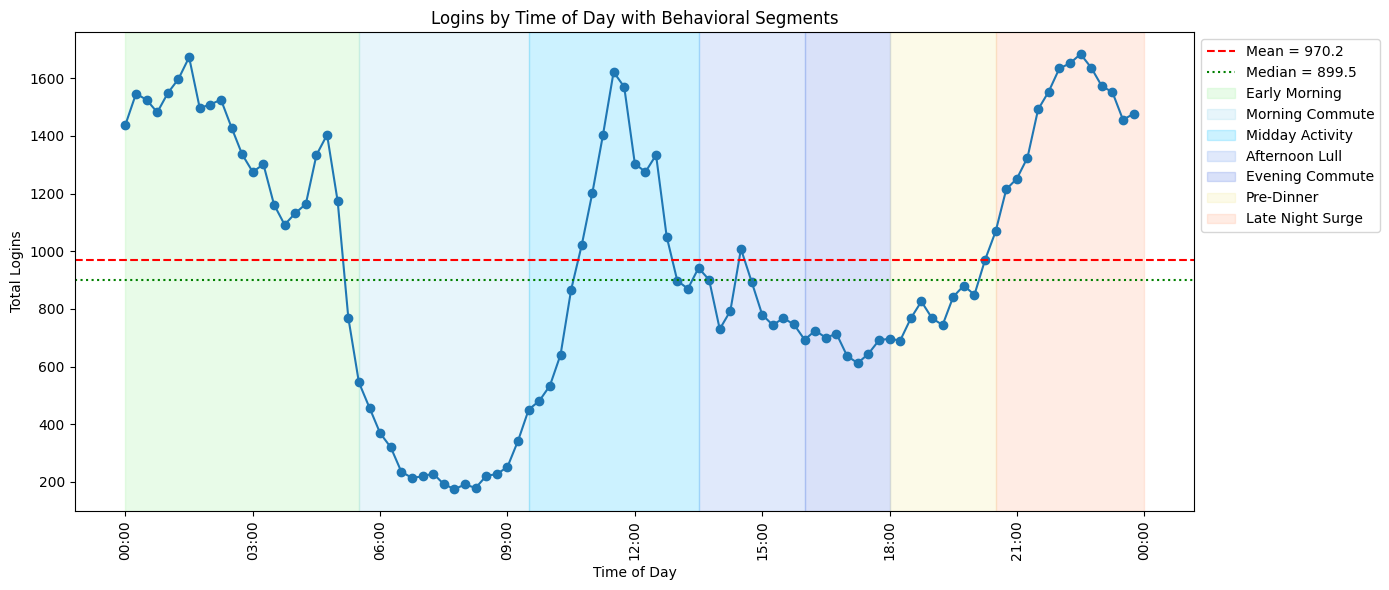

In [60]:
# Ensure login times are datetime with a fixed anchor date
time_of_day_summary['time_of_day_dt'] = pd.to_datetime(
    time_of_day_summary['time_of_day'].astype(str), format='%H:%M:%S'
).apply(lambda x: x.replace(year=1970, month=1, day=1))

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(time_of_day_summary['time_of_day_dt'], time_of_day_summary['count'], marker='o')

# Mean & Median lines
ax.axhline(mean_val, color='red', linestyle='--', label=f'Mean = {mean_val:.1f}')
ax.axhline(median_val, color='green', linestyle=':', label=f'Median = {median_val:.1f}')

# Add shaded behavioral blocks
anchor_date = '1970-01-01'
shaded_blocks = [
    ('00:00', '05:30', 'Early Morning'),
    ('05:30', '09:30', 'Morning Commute'),
    ('09:30', '13:30', 'Midday Activity'),
    ('13:30', '16:00', 'Afternoon Lull'),
    ('16:00', '18:00', 'Evening Commute'),
    ('18:00', '20:30', 'Pre-Dinner'),
    ('20:30', '23:59', 'Late Night Surge'),
]

colors = [
    'lightgreen',     # Early Morning
    'skyblue',       # Morning Commute
    'deepskyblue',   # Midday Activity
    'cornflowerblue',# Afternoon Lull
    'royalblue',     # Evening Commute
    'khaki',         # Pre-Dinner
    'lightsalmon',   # Late Night Surge
]

for (start_str, end_str, label), color in zip(shaded_blocks, colors):
    start = pd.to_datetime(f"{anchor_date} {start_str}")
    end = pd.to_datetime(f"{anchor_date} {end_str}")
    ax.axvspan(start, end, alpha=0.2, color=color, label=label)

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_title('Logins by Time of Day with Behavioral Segments')
ax.set_xlabel('Time of Day')
ax.set_ylabel('Total Logins')
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


In [61]:
# Checking for Duplicate Rows (Based on All Columns):

# Check for duplicate rows
duplicate_rows = ult_data[ult_data.duplicated()]

# Print the duplicate rows
#print("Duplicate Rows (based on all columns):")
#print(duplicate_rows)

# Get the number of duplicate rows
num_duplicate_rows = duplicate_rows.shape[0]
print(f"\nNumber of duplicate rows: {num_duplicate_rows}")

# To see all unique rows (removing duplicates):
ult_data_unique_rows = ult_data.drop_duplicates()
print("\nDataFrame with duplicate rows removed:")
print(f"Shape of DataFrame with duplicates removed: {ult_data_unique_rows.shape}")
ult_data_unique_rows.head()



Number of duplicate rows: 877

DataFrame with duplicate rows removed:
Shape of DataFrame with duplicates removed: (92265, 2)


,login_time,login_time_15min
0,1970-01-01 20:13:18,1970-01-01 20:00:00
1,1970-01-01 20:16:10,1970-01-01 20:15:00
2,1970-01-01 20:16:37,1970-01-01 20:15:00
3,1970-01-01 20:16:36,1970-01-01 20:15:00
4,1970-01-01 20:26:21,1970-01-01 20:15:00


In [62]:
# Find login timestamps that appear 3 or more times:
n_plus_duplicate_timestamps_df = find_n_plus_duplicate_timestamps(ult_data, n=3)
print("\nLogin timestamps appearing 3 or more times:")
print(n_plus_duplicate_timestamps_df)


Login timestamps appearing 3 or more times:
               login_time    login_time_15min
3253  1970-01-06 21:45:52 1970-01-06 21:45:00
3256  1970-01-06 21:45:52 1970-01-06 21:45:00
3259  1970-01-06 21:45:52 1970-01-06 21:45:00
4744  1970-01-09 01:31:25 1970-01-09 01:30:00
4750  1970-01-09 01:31:25 1970-01-09 01:30:00
4757  1970-01-09 01:31:25 1970-01-09 01:30:00
29774 1970-02-12 11:16:53 1970-02-12 11:15:00
29790 1970-02-12 11:16:53 1970-02-12 11:15:00
29797 1970-02-12 11:16:53 1970-02-12 11:15:00
41874 1970-02-24 23:09:57 1970-02-24 23:00:00
41877 1970-02-24 23:09:57 1970-02-24 23:00:00
41883 1970-02-24 23:09:57 1970-02-24 23:00:00
59819 1970-03-14 17:45:52 1970-03-14 17:45:00
59806 1970-03-14 17:45:52 1970-03-14 17:45:00
59791 1970-03-14 17:45:52 1970-03-14 17:45:00
62890 1970-03-17 01:01:39 1970-03-17 01:00:00
62902 1970-03-17 01:01:39 1970-03-17 01:00:00
62908 1970-03-17 01:01:39 1970-03-17 01:00:00
77076 1970-03-29 03:24:57 1970-03-29 03:15:00
77094 1970-03-29 03:24:57 1970-03-2

Is it possible for users to log in at the exact same time down to the milliseconds? Yes, we need to keep the data intact and not drop duplicates.

The duplicate rows might be useful for future work. For now, no further analysis or action needed.

### Part 3

In [63]:
# Load the second dataset
shareable_link = "https://drive.google.com/file/d/1buEu5LHKSuK0Pgyu4cpYClOgDnlzdnJY/view?usp=drive_link"
ucity_data = load_and_group_dataframe(shareable_link)

# You can now work with the loaded DataFrame 'df' if it was loaded successfully
if ucity_data is not None:
    # View the new DataFrame for further analysis or processing
    print("\nDataFrame shape:", ucity_data.shape)

Data loaded successfully from Google Drive:

DataFrame shape: (50000, 12)


In [64]:
ucity_data.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [65]:
ucity_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [66]:
ucity_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [67]:
# Separate numerical and non-numerical columns
numerical_cols = ucity_data.select_dtypes(include=['number']).columns.tolist()
non_numerical_cols = ucity_data.select_dtypes(exclude=['number']).columns.tolist()

# Create the desired column order
ordered_cols = numerical_cols + non_numerical_cols

# Display the DataFrame with the ordered columns (showing the head)
#ucity_data[ordered_cols].head()

# If you want to see all columns without truncation in the output:
# pd.set_option('display.max_columns', None)
# print(ut_data[ordered_cols])

In [68]:
# Phone column is not useful
ucity_data.drop(columns=['phone'], inplace=True)

In [69]:
ucity_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9


In [70]:
# Copy the original DataFrame
df_model = ucity_data.copy()

# Seed for reproducibility
np.random.seed(42)

# Create random 'yes'/'no' for reimbursed and post_policy
df_model['reimbursed'] = np.random.choice(['yes', 'no'], size=len(df_model))
df_model['post_policy'] = np.random.choice(['yes', 'no'], size=len(df_model))

# Convert to binary
df_model['reimbursed'] = (df_model['reimbursed'] == 'yes').astype(int)
df_model['post_policy'] = (df_model['post_policy'] == 'yes').astype(int)


In [71]:
import statsmodels.formula.api as smf

model = smf.ols(
    formula="avg_rating_of_driver ~ reimbursed * post_policy + city + avg_dist + surge_pct + weekday_pct",
    data=df_model
).fit()

print(model.summary())


                             OLS Regression Results                             
Dep. Variable:     avg_rating_of_driver   R-squared:                       0.014
Model:                              OLS   Adj. R-squared:                  0.014
Method:                   Least Squares   F-statistic:                     74.95
Date:                  Fri, 25 Apr 2025   Prob (F-statistic):          2.33e-123
Time:                          23:21:23   Log-Likelihood:                -38925.
No. Observations:                 41878   AIC:                         7.787e+04
Df Residuals:                     41869   BIC:                         7.795e+04
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercep

In [72]:
# Add random reimbursement counts for demo
np.random.seed(42)
df_model['reimbursement_request_count'] = np.where(
    df_model['reimbursed'] == 1,
    np.random.randint(1, 5, size=len(df_model)),
    0
)


In [73]:
model_reimb = smf.ols(
    formula="reimbursement_request_count ~ reimbursed * post_policy + city + surge_pct + weekday_pct",
    data=df_model
).fit()

print(model_reimb.summary())


                                 OLS Regression Results                                
Dep. Variable:     reimbursement_request_count   R-squared:                       0.665
Model:                                     OLS   Adj. R-squared:                  0.665
Method:                          Least Squares   F-statistic:                 1.416e+04
Date:                         Fri, 25 Apr 2025   Prob (F-statistic):               0.00
Time:                                 23:21:23   Log-Likelihood:                -53659.
No. Observations:                        50000   AIC:                         1.073e+05
Df Residuals:                            49992   BIC:                         1.074e+05
Df Model:                                    7                                         
Covariance Type:                     nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [74]:
model_dist = smf.ols(
    formula="avg_dist ~ reimbursed * post_policy + city + surge_pct + weekday_pct",
    data=df_model
).fit()

print(model_dist.summary())


                            OLS Regression Results                            
Dep. Variable:               avg_dist   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     147.3
Date:                Fri, 25 Apr 2025   Prob (F-statistic):          3.82e-216
Time:                        23:21:23   Log-Likelihood:            -1.5752e+05
No. Observations:               50000   AIC:                         3.151e+05
Df Residuals:                   49992   BIC:                         3.151e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  4

In [75]:
null_data = ucity_data.isnull().sum()
null_data.sort_values(ascending=False)


,0
avg_rating_of_driver,8122
avg_rating_by_driver,201
city,0
signup_date,0
trips_in_first_30_days,0
last_trip_date,0
avg_surge,0
surge_pct,0
ultimate_black_user,0
weekday_pct,0


In [76]:
count_od = ucity_data['avg_rating_of_driver'].count()
count_bd = ucity_data['avg_rating_by_driver'].count()

In [77]:
avg_rtg_pct =null_data/len(ucity_data)*100

#avg_rtg_pct.sort_values(ascending=False)
sorted_and_formatted = avg_rtg_pct.sort_values(ascending=False).map('{:.2f}%'.format)

print("Average Rating Percentages (Highest to Lowest):\n", sorted_and_formatted)

Average Rating Percentages (Highest to Lowest):
 avg_rating_of_driver      16.24%
avg_rating_by_driver       0.40%
city                       0.00%
signup_date                0.00%
trips_in_first_30_days     0.00%
last_trip_date             0.00%
avg_surge                  0.00%
surge_pct                  0.00%
ultimate_black_user        0.00%
weekday_pct                0.00%
avg_dist                   0.00%
dtype: object


We only have to features with null values. Average rating by drive is missing 0.4%. This is not significant so I will randomly impute the values.

Average rating of drive is missing 16.24%. imputing the highest or lowest will likely skew the data. I will impute by mean.

In [78]:
# Calculate the mean of 'avg_rating_of_driver' excluding NaN values
mean_driver_rating = ucity_data['avg_rating_of_driver'].mean()

# Impute the NaN values in 'avg_rating_of_driver' with the calculated mean
ucity_data['avg_rating_of_driver'] = ucity_data['avg_rating_of_driver'].fillna(mean_driver_rating)

# Calculate the mean of 'avg_rating_by_driver' excluding NaN values
mean_by_driver_rating = ucity_data['avg_rating_by_driver'].mean()

# Impute the NaN values in 'avg_rating_by_driver' with the calculated mean
ucity_data['avg_rating_by_driver'] = ucity_data['avg_rating_by_driver'].fillna(mean_by_driver_rating)

# Verify that the null values have been imputed
print(f"Null values after imputing\n",ucity_data[['avg_rating_of_driver', 'avg_rating_by_driver']].isnull().sum())

Null values after imputing
 avg_rating_of_driver    0
avg_rating_by_driver    0
dtype: int64


No more null values

In [79]:
# Convert date features from object to datetinme type
for col in ['signup_date', 'last_trip_date']:
    if ucity_data[col].dtype == 'object':
        ucity_data[col] = pd.to_datetime(ucity_data[col], errors='coerce')

assert np.issubdtype(ucity_data['signup_date'].dtype, np.datetime64), "signup_date not datetime!"
assert np.issubdtype(ucity_data['last_trip_date'].dtype, np.datetime64), "last_trip_date not datetime!"


In [80]:
ucity_data['last_trip_date'].max()

Timestamp('2014-07-01 00:00:00')

In [81]:
ucity_data['signup_date'].min()

Timestamp('2014-01-01 00:00:00')

Assumptions:
*   Every row is a unique user. The data set does not show historical trip and only last trip.
*   The start of the program is 1/1/2014
*   The date the data is pulled is on 7/2/2014 (1 day after max last trip)
*   The date the data is pulled is on 7/2/2014 (1 day after max last trip)
*   I will use the date in no. 2 to find activities in preceeding 30 days

How many users used the service in the last 30 days from 7-2-2014?

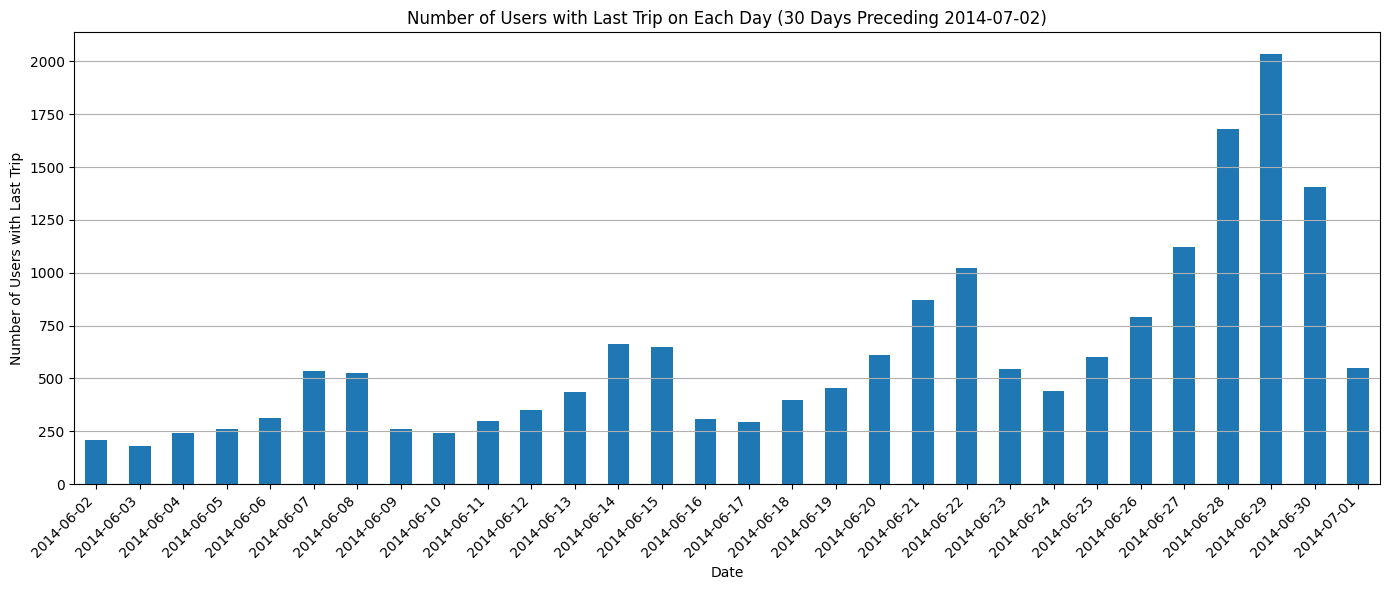


Interpretation of the Plot:
This bar plot shows, for each day in the 30 days leading up to July 2nd, 2014,
the number of users whose last recorded trip in the dataset occurred on that specific day.
This can be interpreted as a daily measure of user churn or last engagement.


In [82]:
# Define the end date of your single window
window_end_date = pd.to_datetime('2014-07-02')

# Define the start date of your 30-day window
window_start_date = window_end_date - pd.Timedelta(days=30)

# Create an empty dictionary to store the daily active users (last trip on that day)
daily_last_trips = {}

# Iterate through each day within the 30-day window
current_date = window_start_date
while current_date < window_end_date:
    # Count users whose last trip date is exactly the current date
    daily_count = len(ucity_data[ucity_data['last_trip_date'] == current_date])
    daily_last_trips[current_date.date()] = daily_count

    # Move to the next day
    current_date += pd.Timedelta(days=1)

# Convert the results dictionary to a Pandas Series for easy plotting
daily_last_trips_series = pd.Series(daily_last_trips)

# Plot the daily last trips
plt.figure(figsize=(14, 6))
daily_last_trips_series.plot(kind='bar')
plt.title('Number of Users with Last Trip on Each Day (30 Days Preceding 2014-07-02)')
plt.xlabel('Date')
plt.ylabel('Number of Users with Last Trip')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

print("\nInterpretation of the Plot:")
print("This bar plot shows, for each day in the 30 days leading up to July 2nd, 2014,")
print("the number of users whose last recorded trip in the dataset occurred on that specific day.")
print("This can be interpreted as a daily measure of user churn or last engagement.")

How many of the users above signed up more that 30 days ago form 7-2-2014?
This is valuable to check for churns. However, the data shows all signups occudered in January of 2014.

In [83]:
ucity_data['signup_date'].min()


Timestamp('2014-01-01 00:00:00')

In [84]:
ucity_data['signup_date'].max()

Timestamp('2014-01-31 00:00:00')

Time to build a model. I will start with Logistic Regression. Unless something glaring presents itself, I will not try a different approach. I will explain in my report why I chose this approach.

In [85]:
# --- 1. Define the Target Variable (Active in June 2014) ---
ucity_data['month_last_trip'] = ucity_data['last_trip_date'].dt.month
ucity_data['was_active_june'] = (ucity_data['month_last_trip'] == 6).astype(int)


# --- 2. Feature Engineering ---
# Time since signup (in days) relative to a fixed point (e.g., max signup date)
max_signup_date = ucity_data['signup_date'].max()
ucity_data['days_since_signup'] = (max_signup_date - ucity_data['signup_date']).dt.days

# --- 3. Data Preparation ---
# Identify categorical and numerical features
categorical_features = ['city', 'ultimate_black_user']
numerical_features = ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
                      'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver',
                      'days_since_signup']

# Separate features (X) and target (y)
X = ucity_data[numerical_features + categorical_features]
y = ucity_data['was_active_june']

# Create preprocessor
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 4. Model Building and Training ---
model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(random_state=42, solver='liblinear'))])

model.fit(X_train, y_train)

# --- 5. Model Evaluation ---
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("Logistic Regression Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

Logistic Regression Model Evaluation:
Accuracy: 0.7013

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.87      0.79      6349
           1       0.65      0.40      0.50      3651

    accuracy                           0.70     10000
   macro avg       0.68      0.64      0.64     10000
weighted avg       0.69      0.70      0.68     10000

AUC: 0.7215


The results show weakness in the model with the feature engineering explored. I will try SVM next.

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer # Keeping this in case you rerun on original data
import numpy as np

# --- 1. Define the Target Variable (Active in June 2014) ---
ucity_data['month_last_trip'] = ucity_data['last_trip_date'].dt.month
ucity_data['was_active_june'] = (ucity_data['month_last_trip'] == 6).astype(int)



# --- 2. Feature Engineering ---
max_signup_date = ucity_data['signup_date'].max()
ucity_data['days_since_signup'] = (max_signup_date - ucity_data['signup_date']).dt.days

# --- 3. Data Preparation ---
categorical_features = ['city', 'ultimate_black_user']
numerical_features = ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
                      'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver',
                      'days_since_signup']

X = ucity_data[numerical_features + categorical_features]
y = ucity_data['was_active_june']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Keeping this
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 4. Model Building and Training (SVM) ---
svm_model = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', SVC(random_state=42, class_weight='balanced',probability=True))]) # probability=True for AUC

svm_model.fit(X_train, y_train)

# --- 5. Model Evaluation (SVM) ---
y_pred_svm = svm_model.predict(X_test)
y_pred_proba_svm = svm_model.predict_proba(X_test)[:, 1]

print("\nSupport Vector Machine Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_svm):.4f}")


Support Vector Machine Model Evaluation:
Accuracy: 0.7521

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.87      0.82      6349
           1       0.71      0.55      0.62      3651

    accuracy                           0.75     10000
   macro avg       0.74      0.71      0.72     10000
weighted avg       0.75      0.75      0.74     10000

AUC: 0.8024


We see an improvement. Before going into hyperparameter optimization, I want to try XGBoost as it is a superior model for tabular data due to its capability to identify non-linear relationships.

In [87]:
# --- 1. Define the Target Variable (Active in June 2014) ---
ucity_data['month_last_trip'] = ucity_data['last_trip_date'].dt.month
ucity_data['was_active_june'] = (ucity_data['month_last_trip'] == 6).astype(int)

# --- 2. Feature Engineering ---
max_signup_date = ucity_data['signup_date'].max()
ucity_data['days_since_signup'] = (max_signup_date - ucity_data['signup_date']).dt.days

# --- 3. Data Preparation ---
categorical_features = ['city', 'ultimate_black_user']
numerical_features = ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
                      'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver',
                      'days_since_signup']

X = ucity_data[numerical_features + categorical_features]
y = ucity_data['was_active_june']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Keeping this
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 4. Model Building and Training (XGBoost) ---
xgb_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss',n_jobs=-1))])

xgb_model.fit(X_train, y_train)

# --- 5. Model Evaluation (XGBoost) ---
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("\nXGBoost Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:33:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Model Evaluation:
Accuracy: 0.7636

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      6349
           1       0.70      0.63      0.66      3651

    accuracy                           0.76     10000
   macro avg       0.75      0.73      0.74     10000
weighted avg       0.76      0.76      0.76     10000

AUC: 0.8298


XGBoost is the most promising of the three models. I will now tune the hyperparamenters accordingly.

In [90]:
# --- 1. Define the Target Variable (Active in June 2014) ---
ucity_data['month_last_trip'] = ucity_data['last_trip_date'].dt.month
ucity_data['was_active_june'] = (ucity_data['month_last_trip'] == 6).astype(int)

# --- 2. Feature Engineering ---
max_signup_date = ucity_data['signup_date'].max()
ucity_data['days_since_signup'] = (max_signup_date - ucity_data['signup_date']).dt.days

# --- 3. Data Preparation ---
categorical_features = ['city', 'ultimate_black_user']
numerical_features = ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
                      'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver',
                      'days_since_signup']

X = ucity_data[numerical_features + categorical_features]
y = ucity_data['was_active_june']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Keeping this
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 4. Model Building and Training (XGBoost with RandomizedSearchCV) ---
param_distributions = {
    'classifier__n_estimators': randint(50, 300),
    'classifier__learning_rate': uniform(0.01, 0.2),  # Reduced upper bound
    'classifier__max_depth': randint(3, 10),
    'classifier__subsample': uniform(0.6, 1.0),
    'classifier__colsample_bytree': uniform(0.6, 1.0),
    'classifier__gamma': uniform(0, 0.5),
    'classifier__reg_alpha': uniform(0, 1),
    'classifier__reg_lambda': uniform(1, 3)
}

random_search = RandomizedSearchCV(xgb_model_tuned,
                                   param_distributions=param_distributions,
                                   n_iter=50,
                                   scoring='roc_auc',
                                   cv=3,
                                   verbose=1,
                                   n_jobs=-1,
                                   error_score='raise',  # Raise errors for debugging
                                   random_state=42)

random_search.fit(X_train, y_train)

# --- 5. Evaluate the Best Model from RandomizedSearchCV ---
best_xgb_model = random_search.best_estimator_
y_pred_best_xgb = best_xgb_model.predict(X_test)
y_pred_proba_best_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

print("\nBest XGBoost Model from RandomizedSearchCV:")
print(random_search.best_params_)
print(f"Best Cross-Validation ROC AUC: {random_search.best_score_:.4f}")

print("\nBest XGBoost Model Evaluation on Test Set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_xgb))
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_best_xgb):.4f}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits


XGBoostError: value 1.46618 for Parameter colsample_bytree exceed bound [0,1]
colsample_bytree: Subsample ratio of columns, resample on each tree construction.

In [94]:
# --- 1. Define the Target Variable (Active in June 2014) ---
ucity_data['month_last_trip'] = ucity_data['last_trip_date'].dt.month
ucity_data['was_active_june'] = (ucity_data['month_last_trip'] == 6).astype(int)

# --- 2. Feature Engineering ---
max_signup_date = ucity_data['signup_date'].max()
ucity_data['days_since_signup'] = (max_signup_date - ucity_data['signup_date']).dt.days

# --- 3. Data Preparation ---
categorical_features = ['city', 'ultimate_black_user']
numerical_features = ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
                      'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver',
                      'days_since_signup']

X = ucity_data[numerical_features + categorical_features]
y = ucity_data['was_active_june']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 4. Model Building and Training (XGBoost with RandomizedSearchCV) ---
param_distributions = {
    'classifier__n_estimators': randint(50, 300),
    'classifier__learning_rate': uniform(0.01, 0.2),
    'classifier__max_depth': randint(3, 10),
    'classifier__subsample': uniform(0.6, 0.4),
    'classifier__colsample_bytree': uniform(0.6, 0.4),
    'classifier__gamma': uniform(0, 0.5),
    'classifier__reg_alpha': uniform(0, 1),
    'classifier__reg_lambda': uniform(1, 2)             # 1 to 3 would work too, but safer here
}

xgb_model_tuned = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', xgb.XGBClassifier(objective='binary:logistic', random_state=42, use_label_encoder=False, eval_metric='logloss'))])

random_search = RandomizedSearchCV(xgb_model_tuned,
                                   param_distributions=param_distributions,
                                   n_iter=50,
                                   scoring='roc_auc',
                                   cv=3,
                                   verbose=1,
                                   n_jobs=-1,
                                   error_score='raise',
                                   random_state=42)

random_search.fit(X_train, y_train)

# --- 5. Evaluate the Best Model from RandomizedSearchCV ---
best_xgb_model = random_search.best_estimator_
y_pred_best_xgb = best_xgb_model.predict(X_test)
y_pred_proba_best_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

print("\nBest XGBoost Model from RandomizedSearchCV:")
print(random_search.best_params_)
print(f"Best Cross-Validation ROC AUC: {random_search.best_score_:.4f}")

print("\nBest XGBoost Model Evaluation on Test Set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_xgb))
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_best_xgb):.4f}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:35:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best XGBoost Model from RandomizedSearchCV:
{'classifier__colsample_bytree': np.float64(0.6186662652854461), 'classifier__gamma': np.float64(0.4868777594207296), 'classifier__learning_rate': np.float64(0.05655426808606085), 'classifier__max_depth': 8, 'classifier__n_estimators': 224, 'classifier__reg_alpha': np.float64(0.6183860093330873), 'classifier__reg_lambda': np.float64(1.7649239825343255), 'classifier__subsample': np.float64(0.9932923543227152)}
Best Cross-Validation ROC AUC: 0.8376

Best XGBoost Model Evaluation on Test Set:
Accuracy: 0.7709

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.85      0.82      6349
           1       0.71      0.63      0.67      3651

    accuracy                           0.77     10000
   macro avg       0.75      0.74      0.75     10000
weighted avg       0.77      0.77      0.77     10000

AUC: 0.8372


preventing future date leakage by limiting the date range to be 6 months from signup

In [108]:
# Set censor date per user
ucity_data['censor_date'] = (ucity_data['signup_date'] + pd.DateOffset(months=6)).clip(upper=pd.Timestamp('2014-07-01'))


# Calculate the month the user should be active in (signup month + 5)
ucity_data['target_month'] = (ucity_data['signup_date'] + pd.DateOffset(months=5)).dt.month

# Only keep users whose 6th month <= July
ucity_data = ucity_data[ucity_data['target_month'] <= 7]

# Clip last trip date at user's 6th month
ucity_data['effective_last_trip_date'] = ucity_data['last_trip_date'].where(
    ucity_data['last_trip_date'] <= ucity_data['censor_date'],
    ucity_data['censor_date']
)



# --- Define Target ---
# Extract month from effective last trip
ucity_data['month_effective_last_trip'] = ucity_data['effective_last_trip_date'].dt.month

# Target: was user active during their 6th month?
ucity_data['was_active_in_6th_month'] = (ucity_data['month_effective_last_trip'] == ucity_data['target_month']).astype(int)



# --- Feature Engineering ---
# Days since last trip (relative to the global censor date July 1, 2014)
ucity_data['days_since_last_trip'] = (ucity_data['censor_date'] - ucity_data['effective_last_trip_date']).dt.days

# Trips per day in first 30 days
ucity_data['trips_per_day_first_30'] = ucity_data['trips_in_first_30_days'] / 30


categorical_features = ['city', 'ultimate_black_user']
numerical_features = [
    'trips_in_first_30_days',
    'avg_rating_of_driver',
    'avg_surge',
    'surge_pct',
    'weekday_pct',
    'avg_dist',
    'avg_rating_by_driver',
    'days_since_last_trip',
    'trips_per_day_first_30'
]


X = ucity_data[numerical_features + categorical_features]
y = ucity_data['was_active_in_6th_month']


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=42,
                                     use_label_encoder=False,
                                     eval_metric='logloss',
                                     **random_search.best_params_)) # optional if you reuse best_params
])

xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred = xgb_model.predict(X_test)

# Predict probabilities for AUC
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC AUC
print(f"AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:35:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "classifier__colsample_bytree", "classifier__gamma", "classifier__learning_rate", "classifier__max_depth", "classifier__n_estimators", "classifier__reg_alpha", "classifier__reg_lambda", "classifier__subsample", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6349
           1       1.00      1.00      1.00      3651

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

AUC: 1.0000
